# Algoritmos genéticos para la optimización en ordenación de trenes

Pongamos en práctica lo aprendido hasta ahora en lo relativo a **algoritmos genéticos**.

La principal utilidad que esta herramienta nos proporciona es la **capacidad de optimizar el resultado a un proceso determinado en un tiempo ínfimo**.

Sabiendo esto, podemos comenzar con el *problema que se nos plantea*.
Existe un área ferroviaria que necesita *optimizar el tiempo de descarga que provocan los trenes entrantes a dicho lugar*. Las condiciones son las siguientes:
1. Todos los trenes circulan por la misma vía, con lo cual si tienen uno delante tienen que esperar.
2. Un tren sólo puede entrar a un muelle de carga que le corresponda, de su mismo tipo.
3. El tiempo de descarga de un tren corresponde al nº de vagones que lleve.

Con lo cual, nuestro cometido será construir un algoritmo genético que reordene los trenes, de forma que el tiempo que están los trenes haciendo cola sea mínimo.

## Funciones auxiliares

A continuación se muestran las funciones propias de los algoritmos genéticos (cruce, mutación, selección), la representación de las clases (trenes, individuos).

In [9]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
import matplotlib.pyplot as plt


# Tren dentro de un individuo
class Train:
    def __init__(self, wagons, op):
        self.wagons = wagons
        self.op = op

    def __str__(self):
        return "Número de vagones:" + str(self.wagons) + "\n" + "Muelle de operaciones:" + str(self.op)

# Función para la generación de trenes con nº aleatorio de trenes y muelle de carga
def random_trains_generation(n):
    train_list = []
    for _ in range(n):
        wagons = random.randint(10, 30)  # Cada tren puede arrastrar entre 10 y 30 vagones
        op = random.choice(["op1", "op2", "op3"])  # A cada tren se le asigna un tipo de carga
        train_list.append(Train(wagons, op))
    return train_list


incoming_trains = random_trains_generation(10)  # supongamos que entran 7 trenes


# Función para la creación de una nueva reordenación de los trenes entrantes, para población incial
def create_queue():
    aux = incoming_trains[:]
    random.shuffle(aux)
    return aux


# Clase para incluir todos los trenes/ crear cada individuo
class Trains(list):
    def __init__(self):
        list.extend(self, create_queue())

        
# Función de fitness
def evaluation(individual):
    dock_op_counters = {"op1" : 0, "op2" : 0, "op3" : 0}
    time = 0

    for train in individual:
        next_delay = train.wagons
        if dock_op_counters[train.op] == 0:
            dock_op_counters[train.op] = next_delay
        else:
            current_delay = dock_op_counters[train.op]
            for k, v in dock_op_counters.items():
                dock_op_counters[k] = max(0, v - current_delay)
            dock_op_counters[train.op] = next_delay
            time += current_delay

    time += max(dock_op_counters.values())
    return time,




# Nuestras funciones

# Función de fitness creada por nosotros (hace lo mismo pero más lento, se intentó)
def time(individual):
    total_count = 0
    dock_1_count = 0
    dock_2_count = 0
    dock_3_count = 0
    
    for train in individual:
        if individual.op == "op1":
            if dock_1_count > 0:
                total_count += dock_1_count
                
                dock_1_count -= dock_1_count
                if dock_1_count < 0:
                    dock_1_count = 0
                dock_2_count -= dock_1_count
                if dock_2_count < 0:
                    dock_2_count = 0
                dock_3_count -= dock_1_count
                if dock_3_count < 0:
                    dock_3_count = 0
                
            dock_1_count += individual.wagons
            
        elif individual.op == "op2":
            if dock_2_count > 0:
                total_count += dock_2_count
                
                dock_1_count -= dock_2_count
                if dock_1_count < 0:
                    dock_1_count = 0
                dock_2_count -= dock_2_count
                if dock_2_count < 0:
                    dock_2_count = 0
                dock_3_count -= dock_2_count
                if dock_3_count < 0:
                    dock_3_count = 0
                
            dock_2_count += individual.wagons
            
        else:
            if dock_3_count > 0:
                total_count += dock_3_count
                
                dock_1_count -= dock_3_count
                if dock_1_count < 0:
                    dock_1_count = 0
                dock_2_count -= dock_3_count
                if dock_2_count < 0:
                    dock_2_count = 0
                dock_3_count -= dock_3_count
                if dock_3_count < 0:
                    dock_3_count = 0
                
            dock_1_count += individual.wagons
            
    final_delays = [dock_1_count, dock_2_count, dock_3_count]
    max_delay = max(final_delays)
    total_count += max_delay
            
    return total_count


# Función de cruce creada por nosotros
def our_crossover(ind1, ind2):
    
    mitad1_ind1 = ind1[: round(len(ind1)/2)]
    mitad2_ind1 = ind1[round(len(ind1)/2): ]
    mitad1_ind2 = ind2[: round(len(ind2)/2)]
    mitad2_ind2 = ind2[round(len(ind2)/2): ]
    
    
    # Comprobación de si hay trenes coincidentes entre la 1ª mitad del 1º y la 2ª mitad del 2º
    for train in mitad2_ind2: 
        if train in mitad1_ind1: # Si hay uno coincidente
            mitad2_ind1.append(train) # Lo meto en la 2ª mitad del 1º
            mitad1_ind1.remove(train) # Lo elimino de la 1ª mitad del 1º, haciendo que el primer hijo ya no lo tenga
            
    # Comprobación de si hay trenes coincidentes entre la 2ª mitad del 1º y la 1ª mitad del 2º        
    for train in mitad2_ind1:
        if train in mitad1_ind2: # Si hay uno coincidente
            mitad2_ind2.append(train) # Lo meto en la 2ª mitad del 2º
            mitad1_ind2.remove(train) # Lo elimino de la 1ª mitad del 2º, haciendo que el segundo hijo ya no lo tenga
         
    ind1 = list(np.append(mitad1_ind1, mitad2_ind2))
    ind2 = list(np.append(mitad2_ind1, mitad1_ind2))
    
    return ind1, ind2


# Función de mutación, creada por nosotros (se intentó)
def our_mutation(ind):
    
    indices = [i for i in range(len(ind))]
    indices_elegidos = random.sample(indices, 2)
    
    # Para la mutación, simplemente cambiaremos 2 trenes de sitio, intercambiando sus posiciones
    train1 = ind[indices_elegidos[0]]
    train2 = ind[indices_elegidos[1]]
    ind[indices_elegidos[0]] = train2
    ind[indices_elegidos[1]] = train1
    
    return ind,


## Puesta a prueba de la creación de individuos

In [10]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,)) # "Creamos" la función de fitness para el algoritmo, 
                                                            # y queremos minimizarla
creator.create("Individual", Trains, fitness=creator.FitnessMax) # Clase Trains, con atributo fitness

toolbox = base.Toolbox()
toolbox.register("individual", creator.Individual) # Individuo
toolbox.register("population", tools.initRepeat, list, toolbox.individual) # La población de individuos

toolbox.register("evaluate", evaluation) # Función de fitness específica
toolbox.register("mate", our_crossover) # tools.cxOrdered, espera índices.
toolbox.register("mutate", tools.mutShuffleIndexes, indpb = 0.03) # Si hiciera falta, sustituir por tools.mutShuffleIndexes (indpb = 0.03) o mutation
toolbox.register("select", tools.selTournament, tournsize = 3) # Función de selección, en este caso por torneo, selTournament
                                                               # puede ser selRandom, selBest, selRoulette

pop = toolbox.population(n=10) # Población de 10 individuos, cada uno con 7 trenes
for ind in pop:
    print(toolbox.evaluate(ind)) # Evaluación de la población inicial, sin cruces ni mutaciones

(105,)
(99,)
(99,)
(110,)
(99,)
(99,)
(120,)
(99,)
(105,)
(110,)


Escogemos la **selección por torneo** porque consideramos que es un buen algoritmo en el que prima bastante la aleatoriedad. 

Desventajas de otros:
- SelRandom: Muy aleatorio, la gracia está en ir dirigiendo la colocación de trenes a aquellos que son mejores, si lo hacemos random difícilmente lo conseguiremos.
- SelBest: Si escogemos siempre el mejor podríamos estar dejando atrás individuos que tienen partes buenas.
- SelRoulette: En caso de haber individuos con mucha más probabilidad de salir, se podrían llegar a perder también buenas características.

Por otro lado, la **función de cruce escogida, cxOrdered**, es ideal porque se caracteriza por *eliminar genes que pudiesen estar duplicados en algún individuo, y mandarlos al otro individuo hijo*.

De esta manera, respetamos que no haya dos mismos trenes en el mismo individuo, repetido.

In [11]:
print("Trenes:")
print("-------\n")
for i in range(len(pop[0])):
    print("Tren %s: %s." % (i, pop[0][i]))

Trenes:
-------

Tren 0: Número de vagones:30
Muelle de operaciones:op3.
Tren 1: Número de vagones:19
Muelle de operaciones:op2.
Tren 2: Número de vagones:25
Muelle de operaciones:op2.
Tren 3: Número de vagones:10
Muelle de operaciones:op1.
Tren 4: Número de vagones:13
Muelle de operaciones:op3.
Tren 5: Número de vagones:16
Muelle de operaciones:op2.
Tren 6: Número de vagones:21
Muelle de operaciones:op1.
Tren 7: Número de vagones:24
Muelle de operaciones:op2.
Tren 8: Número de vagones:15
Muelle de operaciones:op2.
Tren 9: Número de vagones:21
Muelle de operaciones:op1.


Se obtienen unos tiempos que podrían ser buenos, pero lo más probable es que sean malos.

## Tabla del proceso de optimización del algoritmo genético

In [12]:
hallOfFame = tools.HallOfFame(1) # Mantenemos el mejor hasta el momento
stats = tools.Statistics(lambda indiv: indiv.fitness.values) # Parámetro que queremos visualizar, el tiempo /fitness
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.15, ngen=200, stats=stats, halloffame=hallOfFame, 
                                   verbose=True)

gen	nevals	avg  	min	max
0  	10    	104.5	99 	120
[<__main__.Train object at 0x000001E711CFD3F0>, <__main__.Train object at 0x000001E711CFFC10>, <__main__.Train object at 0x000001E711CFF8E0>, <__main__.Train object at 0x000001E711CFD990>, <__main__.Train object at 0x000001E711CFDA20>, <__main__.Train object at 0x000001E711CFF130>, <__main__.Train object at 0x000001E711CFF070>, <__main__.Train object at 0x000001E711CFF0D0>, <__main__.Train object at 0x000001E711CFF0A0>, <__main__.Train object at 0x000001E711CFEF80>]
[<__main__.Train object at 0x000001E711CFE440>, <__main__.Train object at 0x000001E711CFF4C0>, <__main__.Train object at 0x000001E711CFF3D0>, <__main__.Train object at 0x000001E711CFF400>, <__main__.Train object at 0x000001E711CFEE90>, <__main__.Train object at 0x000001E711CFF310>, <__main__.Train object at 0x000001E711CFF250>, <__main__.Train object at 0x000001E711CFF2B0>, <__main__.Train object at 0x000001E711CFF280>, <__main__.Train object at 0x000001E711CFF160>]


AttributeError: 'list' object has no attribute 'fitness'

## Visualización del proceso de optimización del algoritmo genético

El individuo/ orden de trenes que consigue un mejor tiempo es: 

Tren 0: Número de vagones:14
Muelle de operaciones:op1.
Tren 1: Número de vagones:21
Muelle de operaciones:op2.
Tren 2: Número de vagones:27
Muelle de operaciones:op3.
Tren 3: Número de vagones:14
Muelle de operaciones:op1.
Tren 4: Número de vagones:24
Muelle de operaciones:op2.
Tren 5: Número de vagones:24
Muelle de operaciones:op1.
Tren 6: Número de vagones:27
Muelle de operaciones:op3.
Tren 7: Número de vagones:27
Muelle de operaciones:op2.
Tren 8: Número de vagones:24
Muelle de operaciones:op1.
Tren 9: Número de vagones:17
Muelle de operaciones:op3.

Tiempo de: (76.0,) segundos


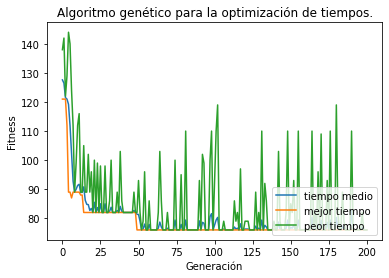

In [175]:
print("El individuo/ orden de trenes que consigue un mejor tiempo es: \n")
for i in range(len(hallOfFame[0])):
    print("Tren %s: %s." % (i, hallOfFame[0][i]))

print("\nTiempo de: %s segundos" % hallOfFame[0].fitness)

gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="tiempo medio")
plt.plot(gen, min_, label="mejor tiempo")
plt.plot(gen, max_, label="peor tiempo")
plt.title("Algoritmo genético para la optimización de tiempos.")
plt.xlabel("Generación")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

Como ppdemos ver, hemos conseguido, con el paso de las generaciones, disminuir el tiempo total de espera de los trenes hasta en 50 unidades, casi la mitad.